In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from pandarallel import pandarallel
import string
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize, pos_tag, ne_chunk
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier
import csv

### Pré-processamento melhor

In [13]:
true_df = pd.read_csv('dados/noticias_combinedtrue.csv')
false_df = pd.read_csv('dados/noticias_combinedfake.csv')

#Remover maiúsculas
true_df['corpo_texto'] = true_df['corpo_texto'].str.lower()
true_df['title'] = true_df['title'].str.lower()
true_df['corpo_texto'] = true_df['corpo_texto'].apply(nltk.word_tokenize)
#true_df['title'] = true_df['title'].apply(nltk.word_tokenize)

false_df['corpo_texto'] = false_df['corpo_texto'].str.lower()
false_df['title'] = false_df['title'].str.lower()
false_df['corpo_texto'] = false_df['corpo_texto'].apply(nltk.word_tokenize)
#false_df['title'] = false_df['title'].apply(nltk.word_tokenize)

stop_words = set(stopwords.words('portuguese'))

#função para remover pontuação
def clean_text(tokens):
    return [re.sub(r'[^\w\s]', '', word) for word in tokens if word not in stop_words and re.sub(r'[^\w\s]', '', word)]

#Remover stop_words

true_df['corpo_texto'] = true_df['corpo_texto'].apply(clean_text)
false_df['corpo_texto'] = false_df['corpo_texto'].apply(clean_text)
#true_df['title'] = true_df['title'].apply(clean_text)
#false_df['title'] = false_df['title'].apply(clean_text)

display(true_df, false_df)

,title,link,date,Site,noticia_falsa,corpo_texto
0,covid-19,https://www.gov.br/saude/pt-br/assuntos/covid-19,Data não disponível,gov.br saude,1,"[covid19, ministério, saúde, ir, conteúdo, 1, ..."
1,vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,gov.br saude,1,"[vacinação, ministério, saúde, ir, conteúdo, 1..."
2,calendário de vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude,1,"[calendário, vacinação, ministério, saúde, ir,..."
3,calendário técnico nacional de vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude,1,"[calendário, técnico, nacional, vacinação, min..."
4,atividades de vacinação de alta qualidade,https://www.gov.br/saude/pt-br/vacinacao/avaq,Data não disponível,gov.br saude,1,"[atividades, vacinação, alta, qualidade, avaq,..."
...,...,...,...,...,...,...
355,decathlon recomendou que pessoas do grupo de r...,http://www.e-farsas.com/decathlon-recomendou-q...,Data não disponível,E-Farsas (Verdadeiros),1,"[decathlon, recomendou, pessoas, grupo, risco,..."
356,governo do maranhão vem fornecendo kits com cl...,http://www.e-farsas.com/governo-do-maranhao-ve...,Data não disponível,E-Farsas (Verdadeiros),1,"[governo, maranhão, vem, fornecendo, kits, clo..."
357,“kit covid-19” para combater o novo coronavíru...,http://www.e-farsas.com/kit-covid-19-para-comb...,Data não disponível,E-Farsas (Verdadeiros),1,"[kit, covid19, combater, novo, coronavírus, ve..."
358,"autoridades, parem de distorcer fatos sobre a ...",http://www.e-farsas.com/autoridades-parem-de-d...,Data não disponível,E-Farsas (Verdadeiros),1,"[autoridades, parem, distorcer, fatos, sobre, ..."


,title,link,date,Site,noticia_falsa,corpo_texto
0,é verdade que o número 95004-1117 aplica o gol...,http://www.e-farsas.com/e-verdade-que-o-numero...,Data não disponível,E-Farsas (Falso),0,"[verdade, número, 950041117, aplica, golpe, va..."
1,a pfizer mudou de nome para viatris para não s...,http://www.e-farsas.com/a-pfizer-mudou-de-nome...,Data não disponível,E-Farsas (Falso),0,"[pfizer, mudou, nome, viatris, responsabilizad..."
2,homem dado como morto pela covid em parauapeba...,http://www.e-farsas.com/homem-dado-como-morto-...,Data não disponível,E-Farsas (Falso),0,"[homem, dado, morto, covid, parauapebas, ressu..."
3,uma patente para um teste de covid-19 foi feit...,http://www.e-farsas.com/uma-patente-para-um-te...,Data não disponível,E-Farsas (Falso),0,"[patente, teste, covid19, feita, 2015, home, s..."
4,o menino luca morreu de parada cardíaca após s...,http://www.e-farsas.com/o-menino-luca-morreu-d...,Data não disponível,E-Farsas (Falso),0,"[menino, luca, morreu, parada, cardíaca, após,..."
...,...,...,...,...,...,...
306,monitoramento dos dados de vacinação,https://www.gov.br/saude/pt-br/vacinacao/monit...,Data não disponível,Gov - Fake,0,"[monitoramento, dados, vacinação, ministério, ..."
307,aquisição emergencial de 25 mil doses,https://agenciagov.ebc.com.br/noticias/202408/...,2024-08-20T16:41:40.382Z,Fato ou fake (G1),0,"[saúde, negocia, aquisição, 25, mil, doses, va..."
308,fake news sobre nanobots em vacinas contra cov...,https://www.boatos.org/saude/nanobots-foram-en...,2024-08-24T15:58:34-03:00,boatos.org,0,"[nanobots, encontrados, milhões, pessoas, vaci..."
309,é falso que brasil seja o único país do mundo ...,https://www.boatos.org/saude/brasil-e-o-unico-...,2024-08-24T15:58:34-03:00,boatos.org,0,"[brasil, único, país, exigir, vacina, contra, ..."


In [14]:
lista_tokens1 = true_df['corpo_texto'].sum()

frequencia_tokenstrue = Counter(lista_tokens1)

df_frequencia_tokenstrue = pd.DataFrame(frequencia_tokenstrue.items(), columns=['token', 'ocorrencia'])
df_frequencia_tokenstrue = df_frequencia_tokenstrue.sort_values(by='ocorrencia', ascending=False)

display(df_frequencia_tokenstrue)

,token,ocorrencia
2,saúde,10768
136,vacinação,4153
200,serviços,2512
192,públicas,2333
161,dados,2228
...,...,...
7009,cӑxыeookk,1
7008,bctnq,1
7007,rjl1pm,1
7006,qv,1


In [15]:
lista_tokens2 = false_df['corpo_texto'].sum()

frequencia_tokensfalse = Counter(lista_tokens2)

df_frequencia_tokensfalse = pd.DataFrame(frequencia_tokensfalse.items(), columns=['token', 'ocorrencia'])
df_frequencia_tokensfalse = df_frequencia_tokensfalse.sort_values(by='ocorrencia', ascending=False)

display(df_frequencia_tokensfalse)

,token,ocorrencia
1105,covid19,1487
0,verdade,1363
746,saúde,1353
9,sobre,1082
687,vida,1011
...,...,...
12538,adiado,1
12541,c4591001,1
12542,estimou,1
12543,concluiria,1


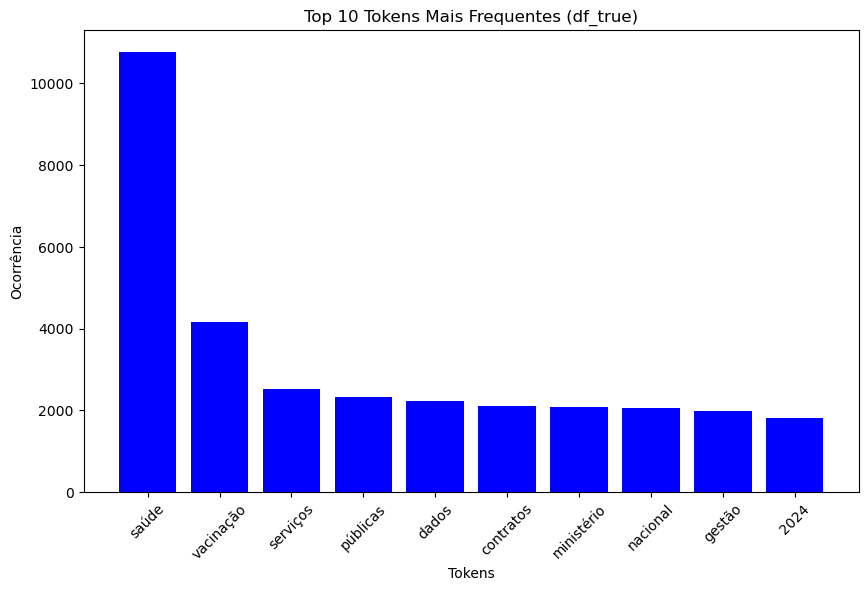

In [16]:
#selecionando os 10 tokens mais frequentes
top_10_tokens = df_frequencia_tokenstrue.head(10)

#plot
plt.figure(figsize=(10, 6))
plt.bar(top_10_tokens['token'], top_10_tokens['ocorrencia'], color='blue')
plt.xlabel('Tokens')
plt.ylabel('Ocorrência')
plt.title('Top 10 Tokens Mais Frequentes (df_true)')
plt.xticks(rotation=45)
plt.show()

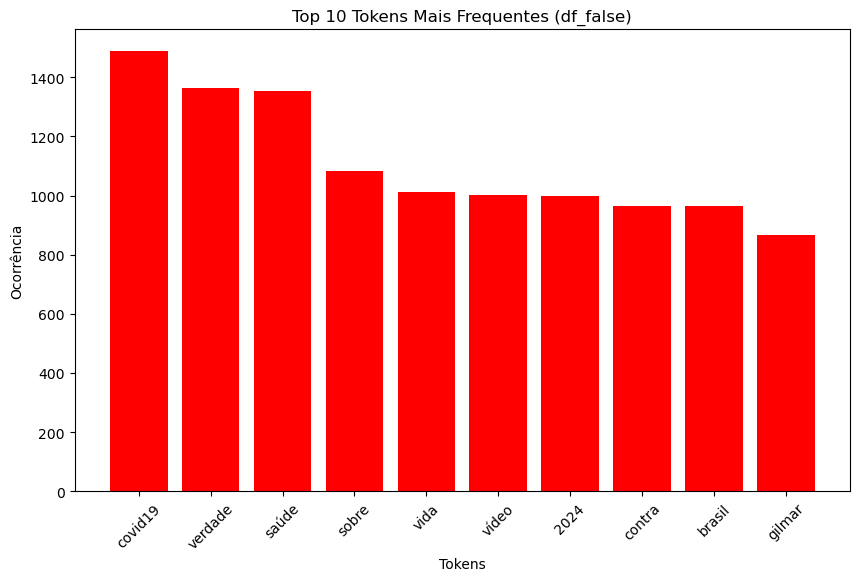

In [17]:
#selecionando os 10 tokens mais frequentes
top_10_tokens2 = df_frequencia_tokensfalse.head(10)

#plot
plt.figure(figsize=(10, 6))
plt.bar(top_10_tokens2['token'], top_10_tokens2['ocorrencia'], color='red')
plt.xlabel('Tokens')
plt.ylabel('Ocorrência')
plt.title('Top 10 Tokens Mais Frequentes (df_false)')
plt.xticks(rotation=45)
plt.show()

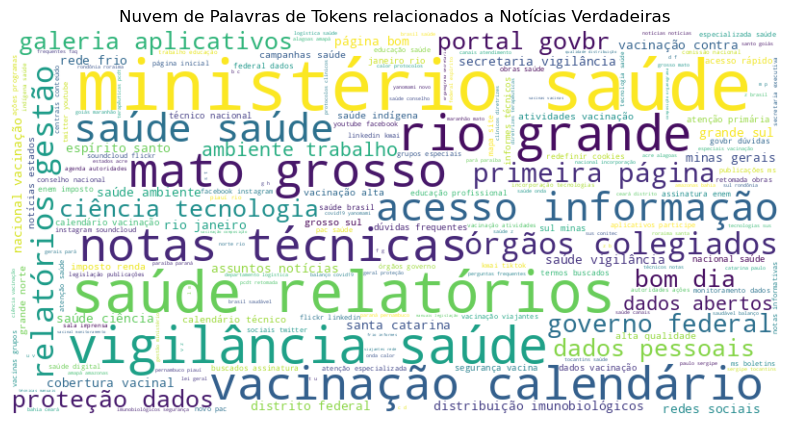

In [18]:
text1 = ' '.join(lista_tokens1)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text1)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Nuvem de Palavras de Tokens relacionados a Notícias Verdadeiras')
plt.show()

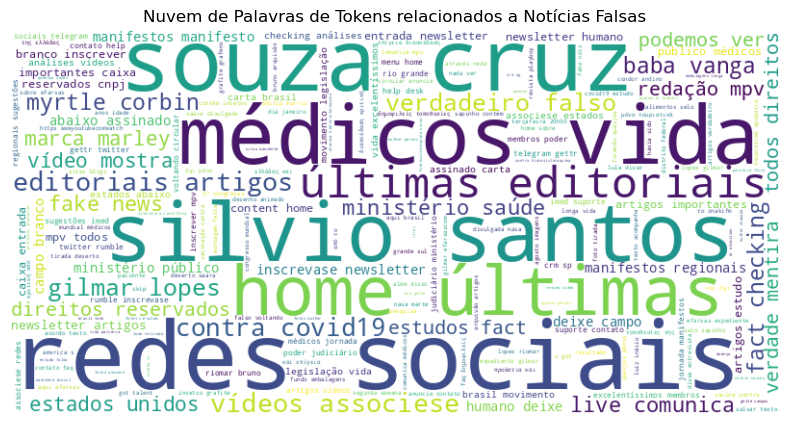

In [19]:
text2 = ' '.join(lista_tokens2)

wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text2)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.title('Nuvem de Palavras de Tokens relacionados a Notícias Falsas')
plt.show()

In [20]:
df_fakerecogna = pd.read_excel('dados/FakeRecogna.xlsx')
df_fakerecogna = df_fakerecogna.loc[df_fakerecogna["Categoria"] == 'saúde']
df_fakerecogna = df_fakerecogna.drop(['Categoria', 'Subtitulo', 'Autor'], axis=1)
df_fakerecogna = df_fakerecogna[['Titulo', 'URL', 'Data', 'Classe', 'Noticia']]
df_fakerecogna = df_fakerecogna.rename(columns = {'Titulo':'title', 'URL': 'link', 'Data': 'date', 'Classe':'noticia_falsa','Noticia':'corpo_texto'})
df_fakerecogna['noticia_falsa'] = df_fakerecogna['noticia_falsa'].astype('int64')
df_fakerecogna

,title,link,date,noticia_falsa,corpo_texto
1,Equador prepara cova coletiva para mortos por ...,https://noticias.uol.com.br/internacional/ulti...,27/03/2020 18h25,1,o governar equador anunciar preparar cova cole...
2,Air France voltará a operar voo direto Pequim-...,https://www.uol.com.br/nossa/noticias/afp/2020...,07/08/2020 13h42,1,o companhia air france operar voar direto pequ...
3,Marfrig intensifica venda de carne do Brasil a...,https://economia.uol.com.br/noticias/reuters/2...,27/04/2020 14h53,1,o marfrig global foods retomar vender carnar b...
6,Coronavírus: sindicatos dos inquilinos convoca...,https://noticias.uol.com.br/internacional/ulti...,30/03/2020 10h38,1,greve pagamento aluguel organizar sindicato in...
9,\n\nVacina contra Covid-19 faz imunidade do co...,https://www.boatos.org/saude/vacina-contra-cov...,27/04/2021,0,“ reação vacinar entender facilidade pessoa in...
...,...,...,...,...,...
11891,\n\nVacinas estão sendo aplicadas com seringas...,https://www.boatos.org/saude/vacinas-aplicadas...,02/01/2021,0,atenção brasil simulação agulhar líquido conse...
11892,Papa vai retomar as audiências públicas das qu...,https://g1.globo.com/mundo/noticia/2020/08/26/...,26/08/2020 08h41,1,o papar francisco retomar audiência público qu...
11899,Ministro se encontra com representantes da ONU...,https://www.gov.br/saude/pt-br/assuntos/notici...,19/04/2021 19h13,1,o ministrar saudar marcelo queiroga e represen...
11900,vídeo mostrar garoto afogar ninguém nado,https://www.e-farsas.com/um-video-mostra-um-ga...,7/05/20197,0,o vídeo recentemente publicar página “ 18:18 ”...


In [21]:
# Combinar DataFrames
combined_df = pd.concat([true_df, false_df, df_fakerecogna], ignore_index=True)

# Limpar e processar a coluna 'title'
combined_df['title'] = combined_df['title'].str.replace('\n', '', regex=False)
combined_df = combined_df.dropna(subset=['title'])

# Filtrar palavras comuns (stopwords)
stop_words = set(stopwords.words('portuguese'))
combined_df['title'] = combined_df['title'].apply(
    lambda i: ' '.join(word for word in i.split() if word not in stop_words)
)

# Remover linhas com títulos vazios
non_empty_titles = combined_df['title'].apply(lambda x: len(x.strip()) > 0)
combined_df = combined_df[non_empty_titles]

# Embaralhar e resetar o índice
combined_df = shuffle(combined_df).reset_index(drop=True)

# Mostrar o DataFrame combinado
display(combined_df)

# Definir o caminho do arquivo CSV
csv_file_path = "dados/combined_df.csv"

# Definir opções de compressão
compression_options = dict(method='zip', archive_name=csv_file_path)

# Salvar o DataFrame como CSV comprimido em um arquivo ZIP
combined_df.to_csv(f'dados/combined_df.zip', index=False, encoding='utf-8', quoting=csv.QUOTE_ALL, escapechar='\\', compression=compression_options)

,title,link,date,Site,noticia_falsa,corpo_texto
0,Espanha reabrirá fronteiras terrestres França ...,https://noticias.uol.com.br/ultimas-noticias/a...,04/06/2020 08h27,NaN,1,o ministro turismo espanha reyes maroto anunci...
1,Rússia proíbe entrada chineses território covi...,https://noticias.uol.com.br/ultimas-noticias/a...,18/02/2020 15h08,NaN,1,o rússia anunciar hoje proibir o entrar cidadã...
2,Covid-19: 'Pandemia Brasil começou três linhag...,https://g1.globo.com/bemestar/coronavirus/noti...,13/11/2020 08h55,NaN,1,pensar trabalhar dinâmico transmissão doença i...
3,nota conjunta ministério relações exteriores m...,https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,gov.br saude,1,"[nota, conjunta, ministério, relações, exterio..."
4,ministério saúde vai repassar r$ 136 milhões c...,https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,gov.br saude,1,"[ministério, saúde, vai, repassar, r, 136, mil..."
...,...,...,...,...,...,...
5119,Associação Brasileira Infectologia (ABI) obrig...,https://www.boatos.org/saude/associacao-de-inf...,22/03/2021,NaN,0,denúncia gravar o associação brasileiro infect...
5120,maioria norte-americanos preocupada segurança ...,https://medicospelavidacovid19.com.br/noticias...,Data não disponível,Médicos Pela Vida,0,"[maioria, norteamericanos, preocupada, seguran..."
5121,Coronavírus: confira próximas lives música cur...,https://entretenimento.uol.com.br/noticias/red...,10/04/2020 04h00,NaN,1,apresentação artista brasileiro web o sucesso ...
5122,É enganoso Coronavac proibida EUA Europa,https://projetocomprova.com.br/publicações/e-e...,2021/05/12,NaN,0,vídeo facebook afirmar o vacinar coronavac lab...
